TODAY

In [26]:
from datetime import datetime

# Get today's date in 'YYYY-MM-DD' format
today_date = datetime.today().strftime('%Y-%m-%d')
print(today_date)

2025-05-26


Finance Data

In [27]:
import yfinance as yf

# Define parameters
symbol = 'MSFT'
start_date = '2000-01-01'
end_date = today_date
output_filename = f'{symbol}_daily_data.csv'

# Download data (make sure to not pass a list)
data = yf.download(symbol, start=start_date, end=end_date, interval='1d')

# Reset index to make 'Date' a column
data.reset_index(inplace=True)

# Save to clean CSV
data.to_csv(output_filename, index=False)



[*********************100%***********************]  1 of 1 completed


In [28]:
import pandas as pd
df = pd.read_csv(output_filename)
# Remove the first row (header row mistakenly read as data)
df = df.iloc[1:].reset_index(drop=True)

# Save the cleaned dataframe back to CSV
df.to_csv(output_filename, index=False)

Training an LSTM Model with Stock Data

In [29]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [30]:
# Load your CSV (must have 'Close' column)
df = pd.read_csv(output_filename)

# Ensure only numerical data
data = df[['Close']].dropna().values

In [31]:
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [32]:
# Create sequences
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

time_steps = 60  # e.g. 60 days
X, y = create_sequences(scaled_data, time_steps)

In [33]:
# Train-test split
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile
model.compile(optimizer='adam', loss='mean_squared_error')

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)



/workspaces/Stock-Market-Prediction-AI-Model/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [34]:
# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# Predict
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

# Evaluate
mae = mean_absolute_error(y_test_rescaled, predictions)
mse = mean_squared_error(y_test_rescaled, predictions)
r2 = r2_score(y_test_rescaled, predictions)
print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}')



Epoch 1/100


158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 8.2017e-04

159/159 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - loss: 8.1509e-04 - val_loss: 0.0092
Epoch 2/100
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.7548e-04

159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 1.7549e-04 - val_loss: 8.5452e-04
Epoch 3/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 1.3185e-04 - val_loss: 0.0057
Epoch 4/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 1.4770e-04 - val_loss: 0.0160
Epoch 5/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 1.6847e-04 - val_loss: 0.0090
Epoch 6/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 1.3539e-04 - val_loss: 0.0053
Epoch 7/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 1.0895e-04 - val_loss: 0.0040
Epoch 8/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 1.3617e-04 - val_loss: 0.0038
Epoch 9/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 1.1415e-04 - val_loss: 0.0133
Epoch 10/100
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.2714e-04

159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 1.2706e-04 - val_loss: 7.5366e-04
Epoch 11/100
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.1534e-04

159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 1.1537e-04 - val_loss: 7.5035e-04
Epoch 12/100
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 1.2883e-04

159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 1.2868e-04 - val_loss: 7.4008e-04
Epoch 13/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 1.2879e-04 - val_loss: 0.0044
Epoch 14/100
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.2593e-04

159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 1.2586e-04 - val_loss: 6.9488e-04
Epoch 15/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 1.3970e-04 - val_loss: 0.0060
Epoch 16/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 1.4319e-04 - val_loss: 7.8089e-04
Epoch 17/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 1.2810e-04 - val_loss: 0.0087
Epoch 18/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 1.2026e-04 - val_loss: 0.0029
Epoch 19/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 1.1460e-04 - val_loss: 0.0138
Epoch 20/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 1.1882e-04 - val_loss: 0.0079
Epoch 21/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 1.3554e-04 - val_loss: 0.0015
Epoch 22/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 1.6388e-04 - val_loss: 0.0013
Epoch 23/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 1.2481e-04 - val_loss: 0.0027
Epoch 24/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 1.36

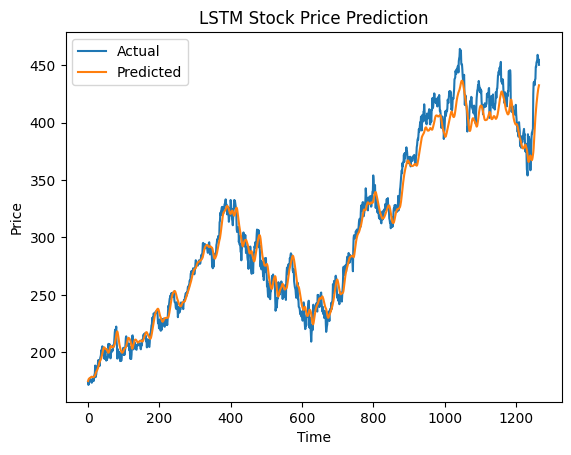

In [35]:
# Plot results
plt.plot(y_test_rescaled, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()